# Modeling Growth of Pair of Bubbles in PPG 2700

In this notebook, I model the growth of two bubbles that nucleated a few hundred microns apart inside an inner stream of PPG 2700 + CO2 ensheathed in VORANOL 360.

I have diffusivity data for PPG 2700 from G-ADSA performed at the University of Naples in 2019. The video analyzed is `ppg_co2_40000_001-1_050_0226_79_04_10.mp4`, recorded on July 20, 2021 with a Photron NOVA S6 camera in an observation capillary of ID 300 um.

The saturation pressure was about **70 bar**.

To run this code, first determine the following parameters of your experiment:

1. The viscosity of the fluid used in the outer stream $\eta_o$ in Pa.s. This fluid is a pure polyol, so its viscosity should be measured precisely with a rheometer (e.g., ARES). If the fluid is VORANOL 360 (1k5f), its viscosity at 24.5 C is 4.815 Pa.s (see `REFERENCES/Materials/viscosity/`).
2. Velocity of the inner stream [m/s]. This should be measured by tracking bubbles in the inner stream, either with image processing or manually.
3. Radius of the inner stream $R_i$ [m]. This should be measured by evaluating the width of the inner stream with image processing or manually (by eye and measuring pixel values, converting to meters with calibration slide) and divided by 2 (to convert from diameter to radius).
4. The inner stream viscosity $\eta_i$ in Pa.s The inner stream will likely have additives (CO2, cyclopentane, etc.), so its viscosity will be challenging to measure directly. Instead, estimate it indirectly using the velocity of the inner stream, pressure in the ISCO pumps, and width of the inner stream. Code to make this estimation is written up in `ANALYSIS/flow/20210720_70bar_ppg_co2.ipynb`.
5. Length $l_{tube,o}$ and inner radius $r_{tube,o}$ of the tubing between the outer stream ISCO pump (ISCO 260 D) and the microfluidic device. Values are usually 0.34 m and $472 \times 10^{-6}$m, respectively.
6. Length of the observation capillary (typically 0.1 m).
7. Inner radius of observation capillary $R_o$ in meters.
8. Inner and outer stream flow rates, $Q_i$ and $Q_o$, which should be read during the experiment from the ISCO pumps.
9. Saturation pressure of Parr reactor where inner stream was prepared [Pa]. This should be read from calibrated pressure transducer's LED readout before the first transfer of the fluid to the ISCO 100 DM syringe pump.
10. Polyol solubility values at different pressures. This can be predicted by PC-SAFT after fitting $N$, $\epsilon$, $k_{ij}$, and $\sigma$ to solubility and specific volume data at different temperatures (measured with G-ADSA at Di Maio lab at the U Naples). Once parameters have been fit, predictions can be made under different conditions. See `ppg2700_binary.nb`, which was used to make predictions to fill in `blkrho.inp` in `dft_string_method/bi_surf/` on Wang group server (read `README.txt` in that same folder on the Wang group server for more details).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src/')
sys.path.append('../libs/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import polyco2
import bubbleflow
import analytics as an
import diffn
import bubble
import flow
import plot.bubble as pltb
import plot.genl as pltg
import plot.diffn as pltd

# CONVERSIONS
from conversions import *
# CONSTANTS
from constants import *

from importlib import reload
reload(bubbleflow)

# viscosity of inner and outer streams [Pa.s]
eta_i = 0.025 # see flow/20210720_70bar_ppg_co2.ipynb for estimation
eta_o = 4.815
l_tube_o = 0.34 # length of tube for outer stream [m]
r_tube_o = 472E-6 # internal radius of tube for outer stream, approx [m]
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
# inner stream flow rate [uL/min]
Q_i = 50*uLmin_2_m3s
# outer stream flow rate, input to ISCO 260 D [uL/min]
Q_o = 226*uLmin_2_m3s 
# saturation pressure [Pa]
p_s = 70E5
# measured values 
v = 0.62 # center stream velocity [m/s] based on "Dimenions > Manual Tracking" option on PFV4, 
# for nucleated bubbles (frames 4688 - 4779 and 9281 - 9355)
# at 40,000 fps and 2.29 pix per um
d = 0.079 # distance down observation capillary [m]
R_i = 14E-6 # [m] inner stream width measured with PFV4; d = 28 um
# diffusion model parameters 
dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration
# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = 'input/3k2f_31c.csv' # make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
# equation of state data
eos_co2_file = 'input/eos_co2_22-0C.csv'
# pressure in ISCO 260 D -- see p. 42 entry for video 8.8
p_260d = 1383*psi_2_Pa

# bubble growth model parameters
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]
# 3E-9 # initial bubble radius, estimated around prediction in slide 13 of 20200305_aps_march_meeting [m]

# frame rate [fps]
fps = 40000

# filepath to bubble size data
filepath = 'input/ppg_co2_40000_001-1_050_0226_79_04_10/std/data/f_0_1_39922_dist.pkl'
# number of object to track
n = 0
# 0 is leading bubble of 3 that nucleate at beginning, frames 4688 - 4779
# 94 is leading bubble of pair that are already elongated when they enter field of view
# 99 is trailing bubble of 94

# loads radius from data (image-processing estimate)
import pickle as pkl
with open(filepath, 'rb') as f:
    data = pkl.load(f)
bub = data['objects'][n]
idx_valid = np.logical_not(bub['props_raw']['on border'])
R_bubbles = np.asarray(bub['props_proc']['radius [um]'])[idx_valid] * um_2_m
f_bubbles = np.asarray(bub['props_raw']['frame'])[idx_valid]
v = bub['props_proc']['average speed [m/s]']
d = data['metadata']['object_kwargs']['d']
fps = data['metadata']['fps']

t_bubble = d / v # time bubble had traveled down channel [s]

# additional bubbles
t_bubbles = np.asarray([t_bubble + (f - f_bubbles[0])/fps for f in f_bubbles])

In [2]:
for i in range(70):
    print(i)
    print(data['objects'][i]['props_proc']['radius [um]'])

0
[3.2887499698868807, 4.27105063332205, 4.444045627212439, 4.728574182305705, 5.23961969738903, 5.730635026554426, 6.036864154984478, 6.26829275387315, 6.441284649330512, 6.656102468301472, 6.9569910600441345, 7.4292493156783435, 8.103242699960893, 8.44474785774588, 8.538993256865538, 8.752020284929275, 8.539331285402401, 9.297958452705393, 9.58551941584268, 9.905601725356554, 10.308793501802834, 10.391178088131616, 10.663630143950153, 10.877453632146741, 11.064597279417821, 11.313217339488533, 11.383287148130634, 11.615564203728564, 11.807721916965855, 11.939906537251366, 12.309046447570138, 12.195279928061689, 12.68595523280773, 12.954818872776086, 13.205440307936328, 13.646590544016963, 12.673750786768608, 12.85933078043837, 12.977366362740382, 13.087144280895137, 13.175081372235022, 13.552531806581554, 13.589191945934902, 13.72197389922796, 13.835789356481241, 14.037164519029147, 14.178808623158234, 14.361663808166696, 14.425090293426111, 14.667206777507698, 14.812298512583816, 15

### Flow Parameters

In [3]:
# estimates pressure drop down observation capillary from ISCO 260 D [Pa]
p_in = p_260d - flow.p_pois(eta_o, l_tube_o, r_tube_o, Q_o)
# collects relevant parameters
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

# estimates pressure on left and right of field of view
p_left = p_in - (p_in - P_ATM)/L*(d-0.001)
p_center = p_in - (p_in - P_ATM)/L*d
p_right = p_in - (p_in - P_ATM)/L*(d+0.001)
p_nucl = p_in - (p_in - P_ATM)/L*(v*42.7625E-3)

# computes density of pure CO2 at pressure on left and right of field of view
f_rho_co2 = polyco2.interp_rho_co2(eos_co2_file)
rho_co2_left = f_rho_co2(p_left)
rho_co2_right = f_rho_co2(p_right)

print('p_in', p_in)
print('t_bubble', t_bubble)
print('p_left', p_left)
print('p_center', p_center)
print('p_nucl', p_nucl)
print('p_right', p_right)
print('rho_co2_left', rho_co2_left)
print('rho_co2_right', rho_co2_right)
print('R_bubbles', R_bubbles*m_2_um)

p_in 9221554.316093665
t_bubble 0.12477896241319152
p_left 2107755.9495406067
p_center 2016553.40637967
p_nucl 6752357.221944144
p_right 1925350.863218733
rho_co2_left 42.86097215594749
rho_co2_right 38.66201053654429
R_bubbles [ 3.28874997  4.27105063  4.44404563  4.72857418  5.2396197   5.73063503
  6.03686415  6.26829275  6.44128465  6.65610247  6.95699106  7.42924932
  8.1032427   8.44474786  8.53899326  8.75202028  8.53933129  9.29795845
  9.58551942  9.90560173 10.3087935  10.39117809 10.66363014 10.87745363
 11.06459728 11.31321734 11.38328715 11.6155642  11.80772192 11.93990654
 12.30904645 12.19527993 12.68595523 12.95481887 13.20544031 13.64659054
 12.67375079 12.85933078 12.97736636 13.08714428 13.17508137 13.55253181
 13.58919195 13.7219739  13.83578936 14.03716452 14.17880862 14.36166381
 14.42509029 14.66720678 14.81229851 15.09932362 15.21984346 15.31970499
 15.55085339 15.86637437 16.00380147 16.07096285 16.33660418 16.5962182
 16.85078864 17.3714697  17.71221291 17.994

### Epstein-Plesset Model

TODO: edit with parameters of Epstein-Plesset model to fit to growth and identify appropriate diffusivity

In [4]:
def plot_pred_ep_fixed_D(L, eps_params, D):
    dt, p_s, R_nuc, _, p_in, v, polyol_data_file, eos_co2_file = eps_params
    eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

    # fits results to bubble growth model
    growth_fn = bubble.grow
    # arguments for bubble growth model
    dict_args = {'D' : D}
    i_t = 0 # index of t_bub in output of growth_fn
    i_R = 8 # index of R in output of growth_fn
    sigma_R = 0.01 # tolerance of error in radius


    ### TOLMAN LENGTH IS ESSENTIAL!!!
    i_t_nuc = 0

    # increases maximum iterations
    max_iter = 25

    # bounds on nucleation time
    t_nuc_lo = d / v *0.845 # [s]
    t_nuc_hi =  d/v * 1.01 # [s]

    # opens figure to show results of different guesses for bubble nucleation time
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # uses modified shooting method to estimate the nucleation time
    t_nuc, output = an.fit_growth_to_pt(t_bubble, R_bubbles[0], t_nuc_lo, t_nuc_hi, growth_fn, list(eps_params),
                         i_t_nuc, sigma_R=sigma_R, ax=ax, max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args)

    # unpacks output
    t, m, D, p, p_bub, if_tension, c_s, c_bulk, R, rho_co2 = output
    # prints pressure in stream upon nucleation of bubble
    print('p [Pa]', p[0])
    # groups results for plotting
    props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)

    # log time axis
    x_lim = [0.00000005, 25]
    y_lim = [0.001, 300]
    x_log = True
    ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='')
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t, props_list_fit[0]),
                          non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_bulk)
    pltg.legend(ax)

    # linear time axis
    x_lim = [0.0, 5]
    y_lim = [1, 50]
    x_log = False
    ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='')
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_s[0])

    pltg.legend(ax)

    return t, t_nuc, props_list_fit, t_bubbles, R_bubbles, R_i, R_o, v, c_bulk

t_nuc = 115.732 ms and error in R is 8.0409.
t_nuc = 120.880 ms and error in R is 5.4147.
t_nuc = 123.453 ms and error in R is 2.8725.
t_nuc = 124.740 ms and error in R is 0.3344.
t_nuc = 124.097 ms and error in R is 1.8163.
t_nuc = 124.418 ms and error in R is 1.0635.
t_nuc = 124.579 ms and error in R is 0.5130.
t_nuc = 124.660 ms and error in R is 0.1736.
t_nuc = 124.700 ms and error in R is 0.0357.
t_nuc = 124.680 ms and error in R is 0.0656.
t_nuc = 124.690 ms and error in R is 0.0310.
t_nuc = 124.695 ms and error in R is 0.0186.
t_nuc = 124.692 ms and error in R is 0.0033.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 124.692 ms
p [Pa] 2021562.2540579922
Model prediction at fit point is R = 3.261637 um.


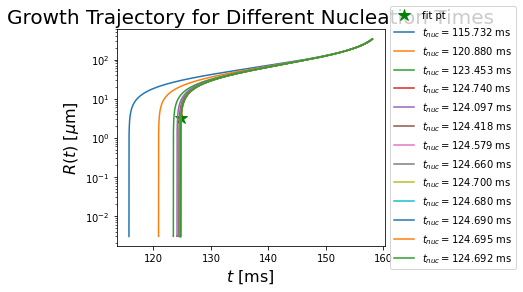

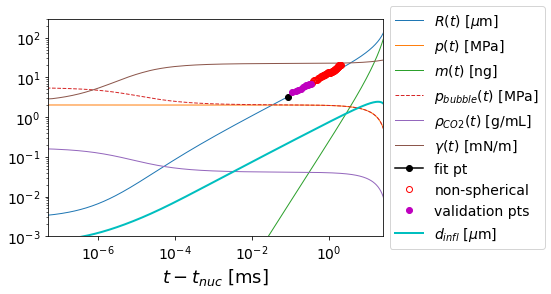

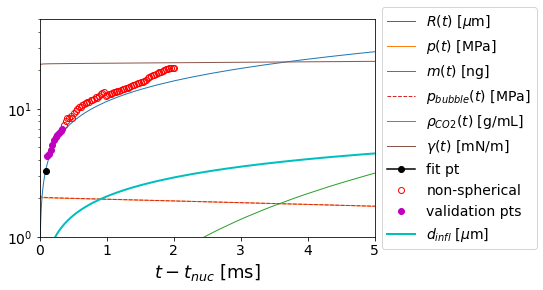

In [22]:
D = 5.5E-9 # [m^2/s]
L = 0.1 # [m]
t, t_nuc, props_list_fit, t_bubbles, R_bubbles, R_i, R_o, v, c_bulk = plot_pred_ep_fixed_D(L, eps_params, D)

#### Plot Results

Model prediction at fit point is R = 3.261637 um.


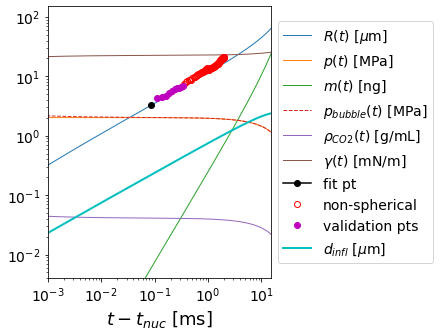

In [23]:
reload(pltb)
# log time axis
x_lim = [1E-3, 1.5E1]
y_lim = [0.004, 150]
x_log = True
fig = plt.figure(figsize=(4,5))
ax = fig.add_subplot(111)
ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t, props_list_fit[0]),
                  non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)


#### Austere Plot for ICTAM Poster

Model prediction at fit point is R = 3.261637 um.


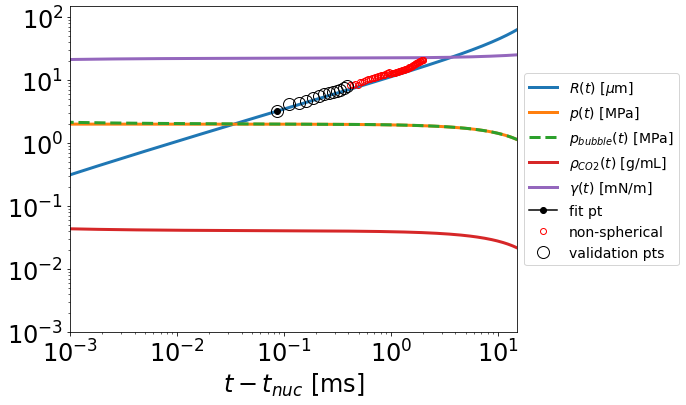

In [25]:
# log time axis
x_lim = [1E-3, 1.5E1]
y_lim = [0.001, 150]
x_log = True
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, 
                    title='', ax=ax, austerity_level=1, lw=3, ax_fs=24, tk_fs=24)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles, R_bubbles[0], R_bubbles, t_R=(t, props_list_fit[0]),
                      non_sph_R=0.6*R_i, ms=12, color='k', fillstyle='none')
# ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)


## Fit Model that Incorporates Concentration Dependence of Diffusivity to Data

In [8]:
# global constants for diffusion model
filepath_D_c='../g-adsa_results/D_c_power_law.csv'
df_D = pd.read_csv(filepath_D_c)
D0, A_p, k_p = df_D['p']

def D_p(c):
    """
    Power-law fit for D(c) fitted to *pressurization* data of 1k3f @ 30c
    (see 20201124_1k3f_D_vs_rho_co2.ipynb).
    """
    return D0 + A_p * c**k_p

# depressurization data-based model of diffusivity
D0, A_dp, k_dp = df_D['dp']

def D_dp(c):
    """
    Power-law fit for D(c) fitted to *depressurization* data of 1k3f @ 30c
    (see 20201124_1k3f_D_vs_rho_co2.ipynb).
    """
    return D0 + A_dp * c**k_dp

In [9]:
reload(diffn)
reload(bubble)
reload(bubbleflow)
reload(an)


def plot_pred(L, eps_params, D_fn, N, eta_ratio=1, R_bubble=-1, d=0.079, t_lo_frac=0.96, max_iter=15):
    dt, p_s, R_nuc, _, p_in, v, polyol_data_file, eos_co2_file = eps_params
    eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

    # fits results to bubble growth model
    growth_fn = bubbleflow.sheath_incompressible
    i_t = 2 # index of t_bub in output of growth_fn
    i_R = 10 # index of R in output of growth_fn
    sigma_R = 0.03 # tolerance of error in radius
    # groups arguments for growth model
    D_max = D_fn(500) # [m^2/s]
    R_max = R_o
    dt_sheath = 0.5*(R_max/N)**2/D_max
    args = [eps_params, R_max, N, R_i, dt_sheath]
    dict_args = {'remesh_fn' : diffn.manage_grid_halving, 
                 'remesh_params' : {'pts_per_grad' : 5, 'interp_kind' : 'quadratic'}, 'D_fn' : D_fn,
                 'remesh_freq' : 100, 'alpha' : 0.3, 'eta_ratio' : eta_ratio} #, 't_f' : t_bubbles[-1]}
    ### TOLMAN LENGTH IS ESSENTIAL!!!
    i_t_nuc = 0
    
    # bounds on nucleation time
    t_nuc_lo = t_lo_frac*d/v #0.05 # [s]
    t_nuc_hi = d/v #0.0516 # [s]

    for i in range(max_iter):
        # opens figure to show results of different guesses for bubble nucleation time
        fig = plt.figure()
        ax = fig.add_subplot(111)

        # radius of bubbles
        if R_bubble == -1:
            R_bubble = R_bubbles[0]
            
        try:
            # uses modified shooting method to estimate the nucleation time
            t_nuc, output = an.fit_growth_to_pt(t_bubble, R_bubble, t_nuc_lo, t_nuc_hi, growth_fn, args,
                                 i_t_nuc, sigma_R=sigma_R, ax=ax, max_iter=max_iter, i_t=i_t, i_R=i_R, 
                                                dict_args=dict_args)

        except:
            print('Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.')
            t_nuc_lo *= 1.01
            print(t_nuc_lo, t_nuc_hi)
            plt.close()
      
    # unpacks output
    t_flow, c, t_bub, m, D, p, p_bub, if_tension, c_bub, c_bulk, R, \
                rho_co2, v, r_arr_data = output
    # prints pressure in stream upon nucleation of bubble
    print('p [Pa]', p[0])
    # groups results for plotting
    props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)
    
    c_s = [c_bulk] 

    # log time axis
    x_lim = [0.00000005, 25]
    y_lim = [0.001, 300]
    x_log = True
    title = 'Linear model for D(c) (pressurization curve)'
    ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubble, R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                          non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_s[0])
    pltg.legend(ax)

    # linear time axis
    x_lim = [0.0, 5]
    y_lim = [1, 50]
    x_log = False
    ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubble, R_bubbles[1:], non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_s[0])

    pltg.legend(ax)
    
    # plot concentration profile
    n_plot = 5

    ax = pltd.sheath_remesh(np.asarray(t_flow), r_arr_data, c, R_i, R_o, v, c_s[0], n_plot, t_nuc=t_nuc)
    ax.set_xscale('log')
    ax.set_xlim([1E-3, 150])
    pltg.legend(ax)
    
    return t_flow, t_bub, t_nuc, props_list_fit, t_bubbles, R_bubbles, r_arr_data, c, R_i, R_o, v, c_s[0]

### Plot Concentration In Inner Stream Over Time

0% complete, t = 0.000 ms.
10% complete, t = 15.800 ms.
20% complete, t = 31.600 ms.
30% complete, t = 47.400 ms.
40% complete, t = 63.200 ms.
50% complete, t = 79.000 ms.
60% complete, t = 94.800 ms.
70% complete, t = 110.567 ms.
regridding
80% complete, t = 126.364 ms.
90% complete, t = 142.165 ms.
Predicted bubble radius is smaller than fit for lowest nucleation time. Terminating early.
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1209856819558305 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1221955387753888 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1234174941631427 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.12465166910477413 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.12589818579582188 0.1247789624131

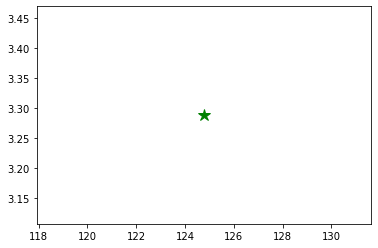

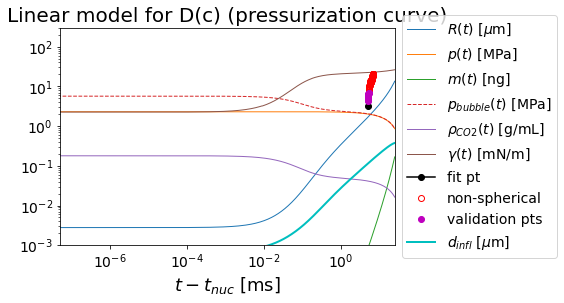

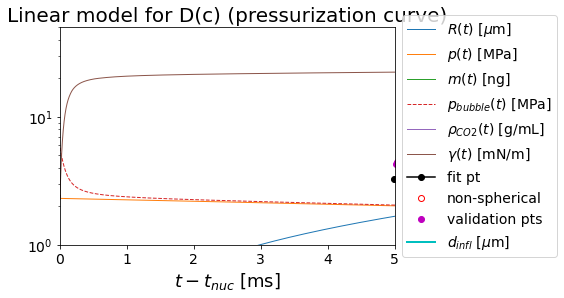

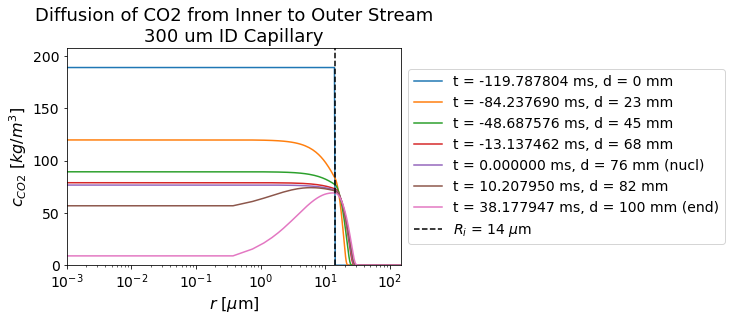

In [10]:
t_flow, t_bub, t_nuc, props_list_fit, t_bubbles, \
R_bubbles, r_arr_data, c, R_i, R_o, v, c_bulk = plot_pred(L, eps_params, D_p, 400, eta_ratio=330/4815, 
                                                          R_bubble=R_bubbles[0])

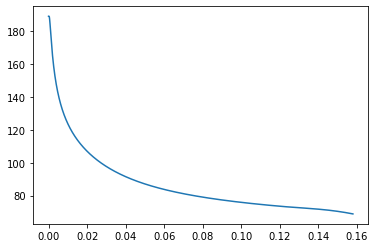

In [11]:
i_r = 30
c_r = [c[i][i_r] for i in range(len(c))]

plt.plot(t_flow, c_r)

### Make Prediction of Nucleation Time for Upper and Lower Bounds on Uncertainty in Radius

Assume that the uncertainty is about a pixel (2.3 $\mu$m)

0% complete, t = 0.000 ms.
10% complete, t = 15.800 ms.
20% complete, t = 31.592 ms.
30% complete, t = 47.392 ms.
40% complete, t = 63.183 ms.
50% complete, t = 78.975 ms.
60% complete, t = 94.775 ms.
70% complete, t = 110.567 ms.
regridding
mass in bubble decreased--density higher than bulk
rho_co2 179.1115049533067
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1209856819558305 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1221955387753888 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1234174941631427 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.12465166910477413 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.12589818579582188 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing

UnboundLocalError: local variable 'output' referenced before assignment

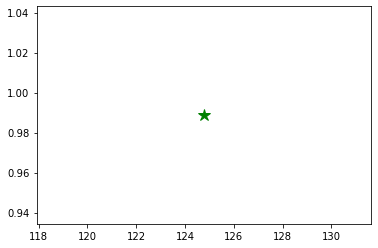

In [12]:
reload(an)

s_R_bubble = 2.3E-6 # [m]

t_flow, t_bub, t_nuc, props_list_fit, t_bubbles, \
R_bubbles, r_arr_data, c, R_i, R_o, v, c_bulk = plot_pred(L, eps_params, D_p, 800, eta_ratio=1, 
                                                          R_bubble=R_bubbles[0]-s_R_bubble)

#### Plot Results

In [ ]:
reload(pltb)
# log time axis
x_lim = [1E-3, 1.5E1]
y_lim = [0.0001, 150]
x_log = True
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                  non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)

In [ ]:
# log time axis
x_lim = [1E-7, 1.5E1]
y_lim = [0.0001, 150]
x_log = True
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                      non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)


### High Estimate

0% complete, t = 0.000 ms.
10% complete, t = 15.800 ms.
20% complete, t = 31.592 ms.
30% complete, t = 47.392 ms.
40% complete, t = 63.183 ms.
50% complete, t = 78.975 ms.
60% complete, t = 94.775 ms.
70% complete, t = 110.567 ms.
regridding
mass in bubble decreased--density higher than bulk
rho_co2 179.1115049533067
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1209856819558305 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1221955387753888 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1234174941631427 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.12465166910477413 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.12589818579582188 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing

UnboundLocalError: local variable 'output' referenced before assignment

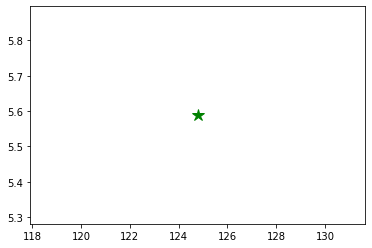

In [13]:
reload(an)

s_R_bubble = 2.3E-6 # [m]

t_flow, t_bub, t_nuc, props_list_fit, t_bubbles, \
R_bubbles, r_arr_data, c, R_i, R_o, v, c_bulk = plot_pred(L, eps_params, D_p, 800, eta_ratio=1, 
                                                          R_bubble=R_bubbles[0]+s_R_bubble)

In [ ]:
reload(pltb)
# log time axis
x_lim = [1E-3, 1.5E1]
y_lim = [0.0001, 150]
x_log = True
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                  non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)

In [ ]:
# log time axis
x_lim = [1E-7, 1.5E1]
y_lim = [0.0001, 150]
x_log = True
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                      non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)


## Compare Effect of Length of Capillary (Proxy for Pressure at the End)

0% complete, t = 0.000 ms.
10% complete, t = 15.800 ms.
20% complete, t = 31.592 ms.
30% complete, t = 47.392 ms.
40% complete, t = 63.183 ms.
50% complete, t = 78.975 ms.
60% complete, t = 94.775 ms.
70% complete, t = 110.567 ms.
regridding
80% complete, t = 126.363 ms.
halving grid
halving grid
remeshed
90% complete, t = 142.160 ms.
Predicted bubble radius is smaller than fit for lowest nucleation time. Terminating early.
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1209856819558305 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1221955387753888 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.1234174941631427 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.
0.12465166910477413 0.12477896241319152
Lower bound on nucleation time too low: CO2 became liquid. Increasing lower bound.


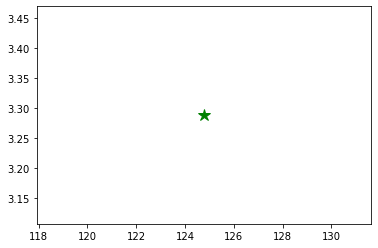

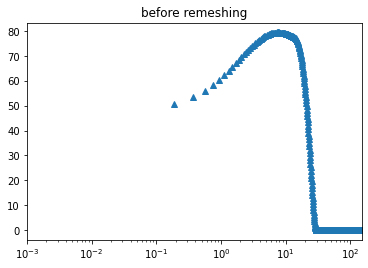

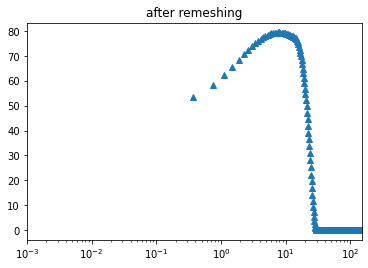

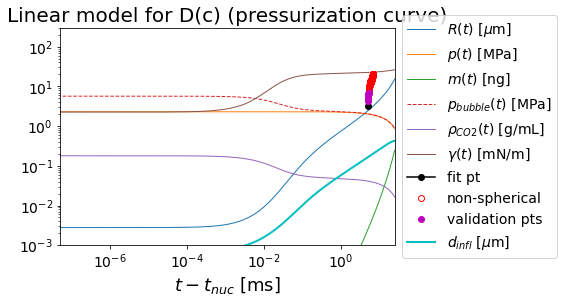

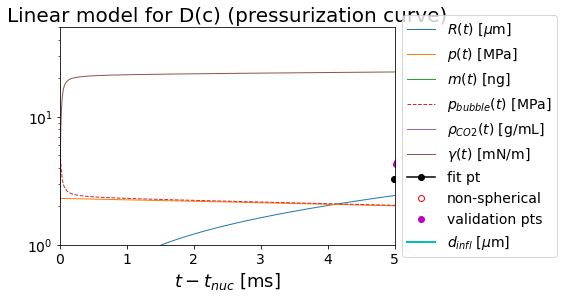

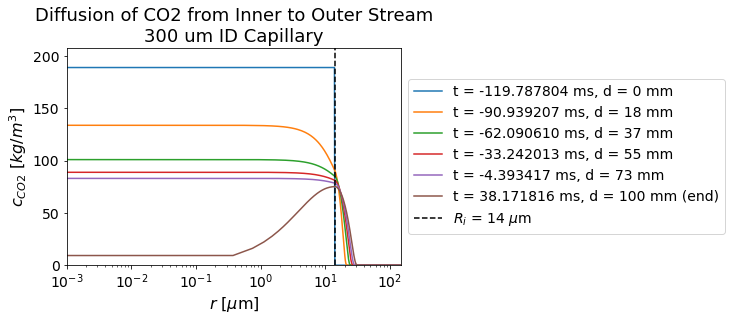

In [14]:
reload(diffn)
reload(bubbleflow)

t_flow, t_bub, t_nuc, props_list_fit, t_bubbles, \
R_bubbles, r_arr_data, c, R_i, R_o, v, c_bulk = plot_pred(L, eps_params, D_dp, 800, eta_ratio=300/4815)

### Plot Results

Model prediction at fit point is R = 2.424434 um.


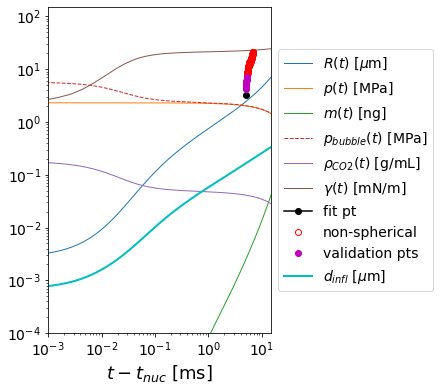

In [15]:
reload(pltb)
# log time axis
x_lim = [1E-3, 1.5E1]
y_lim = [0.0001, 150]
x_log = True
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                  non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)

# saves figure for report
plt.savefig('../../REPORTS/20220122_elongated_bubbles/figs/for_inkscape/eps_pless_underpredicts.svg')

Model prediction at fit point is R = 2.424434 um.


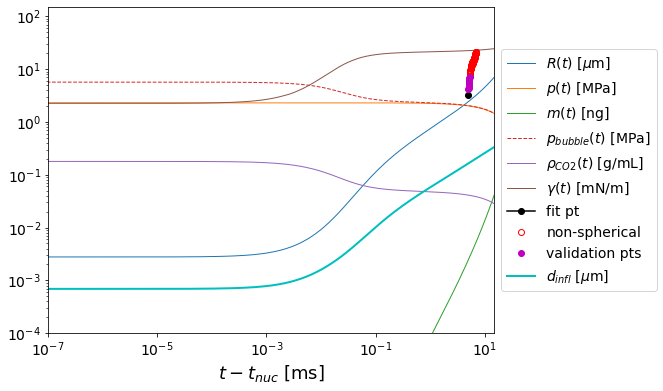

In [16]:
# log time axis
x_lim = [1E-7, 1.5E1]
y_lim = [0.0001, 150]
x_log = True
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title='', ax=ax)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                      non_sph_R=0.5*R_i)
ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)


#### Austere Plot for Presentations

Model prediction at fit point is R = 2.424434 um.


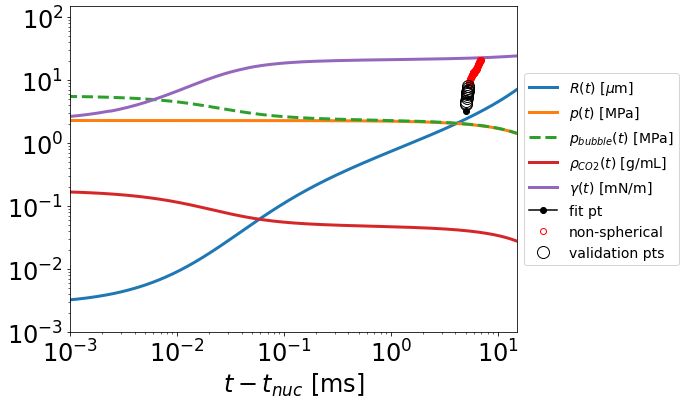

In [20]:
# log time axis
x_lim = [1E-3, 1.5E1]
y_lim = [0.001, 150]
x_log = True
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, 
                    title='', ax=ax, austerity_level=1, lw=3, ax_fs=24, tk_fs=24)
ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                      non_sph_R=0.6*R_i, ms=12, color='k', fillstyle='none')
# ax = pltb.d_infl(ax, t, t_nuc, props_list_fit, c_bulk)
pltg.legend(ax)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

import finitediff as fd

r_arr = r_arr_data[0][-1]

dcdr_arr = fd.dydx_cd_2nd(np.asarray(c[-1]), r_arr[1] - r_arr[0])
D_arr = D_p(np.asarray(c[-1]))

ax.plot(r_arr*m_2_um, c[-1], '--', label=r'$c_{CO2}$ [kg/m$^3$]')
ax.plot(r_arr*m_2_um, 1E11*D_arr, label=r'$D_{CO2}(c)$ [$10^{-11}$ m$^2$/s]')
ax.plot(r_arr[1:-1]*m_2_um, D_arr[1:-1]*dcdr_arr*1000, lw=2, label=r'flux [$10^3$ kg/m$^2$/s]')


ax.set_xlabel(r'$r$ [$\mu$m]', fontsize=16)
ax.set_ylabel(r'$c_{CO2}$ [kg/m$^3$]', fontsize=16)
ax.legend(fontsize=12)

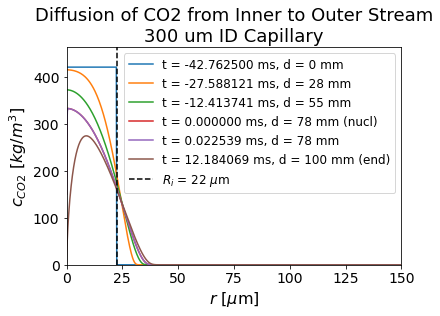

In [92]:
n_plot = 4
reload(pltd)
ax = pltd.sheath_remesh(np.asarray(t_flow), r_arr_data, c, R_i, R_o, v, c_bulk, n_plot, t_nuc=t_nuc)
# pltg.legend(ax)

0% complete, t = 0.000 ms.
10% complete, t = 5.221 ms.
20% complete, t = 10.440 ms.
30% complete, t = 15.661 ms.
40% complete, t = 20.880 ms.
50% complete, t = 26.099 ms.
60% complete, t = 31.320 ms.
70% complete, t = 36.539 ms.
halving grid
halving grid
80% complete, t = 41.762 ms.
90% complete, t = 46.981 ms.
0% complete, t = 0.000 ms.
10% complete, t = 5.221 ms.
20% complete, t = 10.440 ms.
30% complete, t = 15.661 ms.
40% complete, t = 20.880 ms.
50% complete, t = 26.099 ms.
60% complete, t = 31.320 ms.
70% complete, t = 36.539 ms.
80% complete, t = 41.759 ms.
halving grid
halving grid
90% complete, t = 46.981 ms.
t_nuc = 41.700 ms and error in R is 1.2611.
0% complete, t = 0.000 ms.
10% complete, t = 5.221 ms.
20% complete, t = 10.440 ms.
30% complete, t = 15.661 ms.
40% complete, t = 20.880 ms.
50% complete, t = 26.099 ms.
60% complete, t = 31.320 ms.
70% complete, t = 36.539 ms.
80% complete, t = 41.758 ms.
halving grid
halving grid
90% complete, t = 46.979 ms.
t_nuc = 42.550 ms

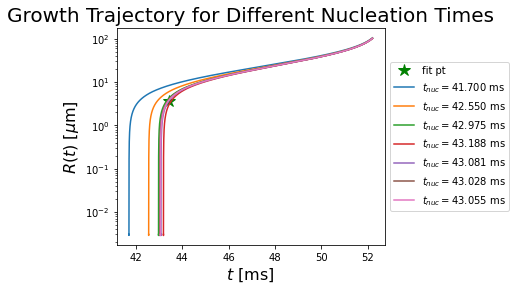

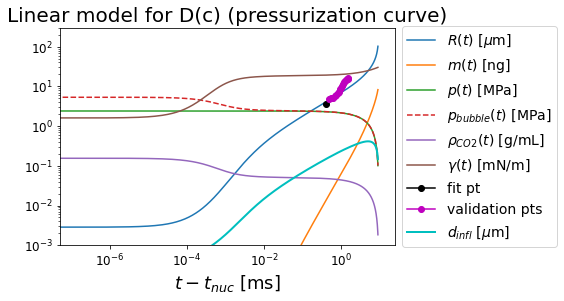

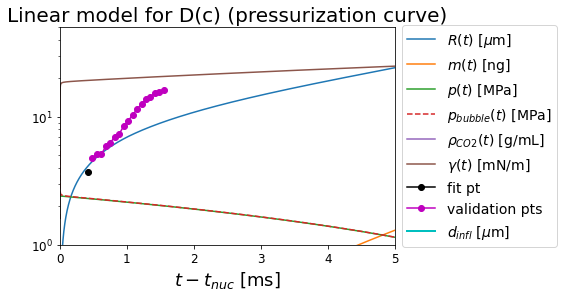

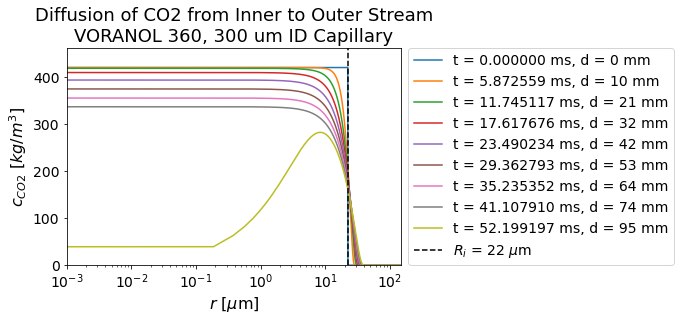

In [52]:
%%time

ax, c, r_arr = plot_pred(0.95*L, eps_params, D_p)

In [64]:
ax.set_xscale('linear')

TypeError: show() got an unexpected keyword argument 'axes'

0% complete, t = 0.000 ms.
10% complete, t = 4.945 ms.
20% complete, t = 9.891 ms.
30% complete, t = 14.836 ms.
40% complete, t = 19.781 ms.
50% complete, t = 24.727 ms.
60% complete, t = 29.670 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.561 ms.
halving grid
halving grid
90% complete, t = 44.506 ms.
0% complete, t = 0.000 ms.
10% complete, t = 4.945 ms.
20% complete, t = 9.891 ms.
30% complete, t = 14.836 ms.
40% complete, t = 19.781 ms.
50% complete, t = 24.727 ms.
60% complete, t = 29.670 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.561 ms.
halving grid
halving grid
90% complete, t = 44.508 ms.
t_nuc = 41.700 ms and error in R is 2.0954.
0% complete, t = 0.000 ms.
10% complete, t = 4.945 ms.
20% complete, t = 9.891 ms.
30% complete, t = 14.836 ms.
40% complete, t = 19.781 ms.
50% complete, t = 24.727 ms.
60% complete, t = 29.670 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.561 ms.
halving grid
halving grid
90% complete, t = 44.511 ms.
t_nuc = 42.550 ms an

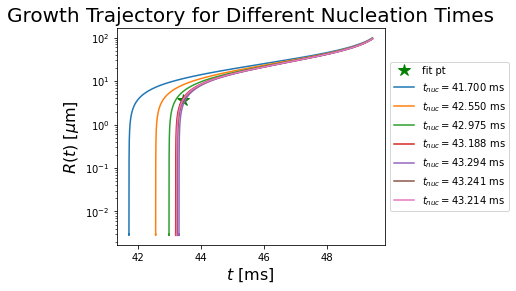

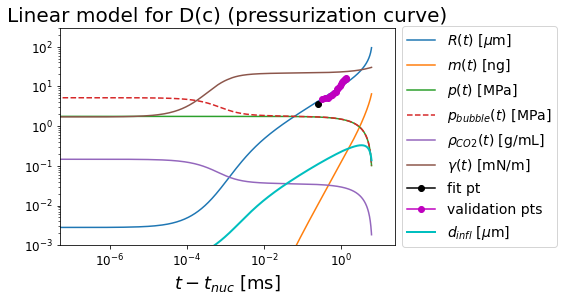

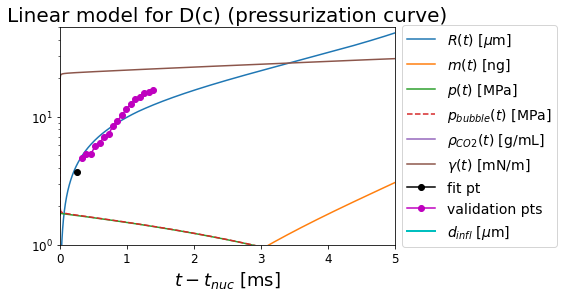

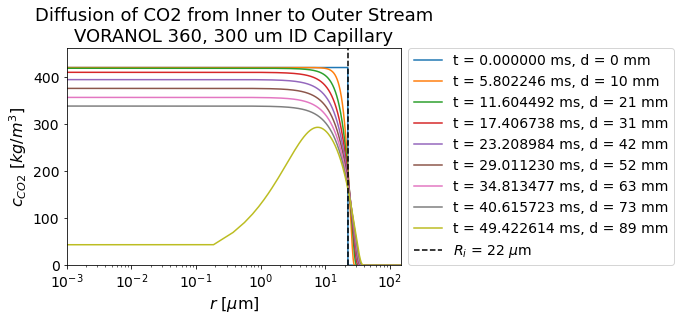

In [53]:
%%time 

ax, c, r_arr = plot_pred(0.9*L, eps_params, D_p)

#### Diffusivity Model Based on Depressurization

0% complete, t = 0.000 ms.
10% complete, t = 5.502 ms.
20% complete, t = 11.003 ms.
30% complete, t = 16.488 ms.
40% complete, t = 21.990 ms.
50% complete, t = 27.474 ms.
60% complete, t = 32.976 ms.
70% complete, t = 38.478 ms.
regridding
80% complete, t = 43.960 ms.
90% complete, t = 49.459 ms.
0% complete, t = 0.000 ms.
10% complete, t = 5.502 ms.
20% complete, t = 11.003 ms.
30% complete, t = 16.488 ms.
40% complete, t = 21.990 ms.
50% complete, t = 27.474 ms.
60% complete, t = 32.976 ms.
70% complete, t = 38.478 ms.
regridding
80% complete, t = 43.962 ms.
90% complete, t = 49.458 ms.
t_nuc = 41.700 ms and error in R is 0.9203.
0% complete, t = 0.000 ms.
10% complete, t = 5.502 ms.
20% complete, t = 11.003 ms.
30% complete, t = 16.488 ms.
40% complete, t = 21.990 ms.
50% complete, t = 27.474 ms.
60% complete, t = 32.976 ms.
70% complete, t = 38.478 ms.
regridding
80% complete, t = 43.963 ms.
90% complete, t = 49.453 ms.
t_nuc = 42.550 ms and error in R is 0.3377.
0% complete, t = 0

ValueError: too many values to unpack (expected 3)

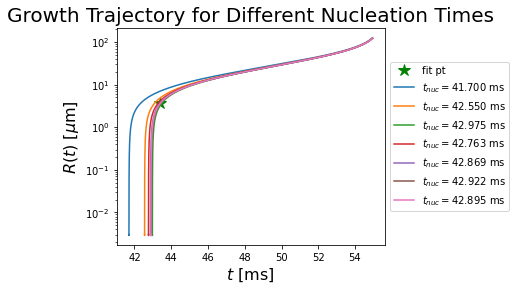

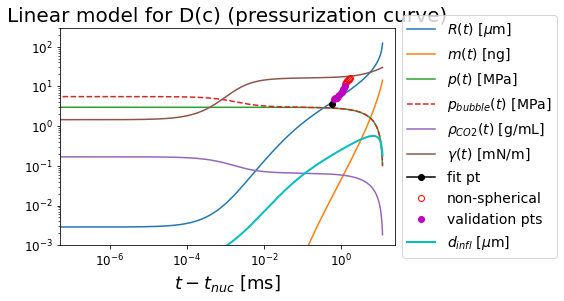

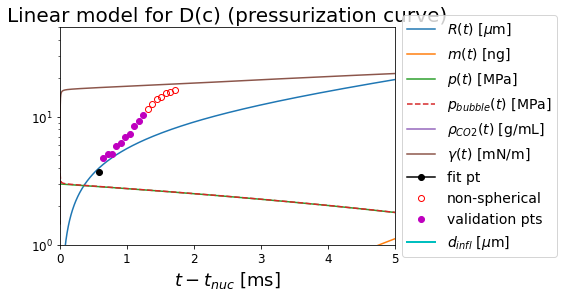

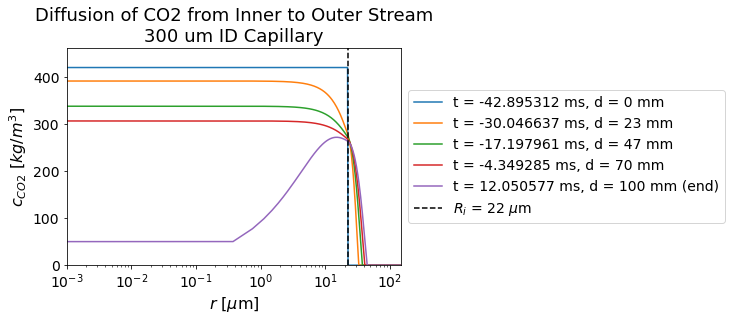

In [10]:
ax, c, r_arr = plot_pred(L, eps_params, D_dp, 400, eta_ratio=300/4815)

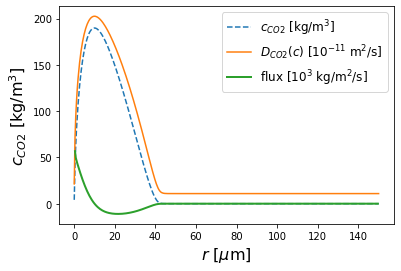

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)

import finitediff as fd

dcdr_arr = fd.dydx_cd_2nd(np.asarray(c), r_arr[1] - r_arr[0])
D_arr = D_dp(np.asarray(c))

ax.plot(r_arr*m_2_um, c, '--', label=r'$c_{CO2}$ [kg/m$^3$]')
ax.plot(r_arr*m_2_um, 1E11*D_arr, label=r'$D_{CO2}(c)$ [$10^{-11}$ m$^2$/s]')
ax.plot(r_arr[1:-1]*m_2_um, D_arr[1:-1]*dcdr_arr*1000, lw=2, label=r'flux [$10^3$ kg/m$^2$/s]')


ax.set_xlabel(r'$r$ [$\mu$m]', fontsize=16)
ax.set_ylabel(r'$c_{CO2}$ [kg/m$^3$]', fontsize=16)
ax.legend(fontsize=12)

0% complete, t = 0.000 ms.
10% complete, t = 5.228 ms.
20% complete, t = 10.457 ms.
30% complete, t = 15.668 ms.
40% complete, t = 20.896 ms.
50% complete, t = 26.107 ms.
60% complete, t = 31.336 ms.
70% complete, t = 36.547 ms.
80% complete, t = 41.768 ms.
90% complete, t = 46.986 ms.
0% complete, t = 0.000 ms.
10% complete, t = 5.228 ms.
20% complete, t = 10.457 ms.
30% complete, t = 15.668 ms.
40% complete, t = 20.896 ms.
50% complete, t = 26.107 ms.
60% complete, t = 31.336 ms.
70% complete, t = 36.547 ms.
80% complete, t = 41.759 ms.
90% complete, t = 46.990 ms.
t_nuc = 41.700 ms and error in R is 0.8027.
0% complete, t = 0.000 ms.
10% complete, t = 5.228 ms.
20% complete, t = 10.457 ms.
30% complete, t = 15.668 ms.
40% complete, t = 20.896 ms.
50% complete, t = 26.107 ms.
60% complete, t = 31.336 ms.
70% complete, t = 36.547 ms.
80% complete, t = 41.775 ms.
90% complete, t = 46.991 ms.
t_nuc = 42.550 ms and error in R is 0.2444.
0% complete, t = 0.000 ms.
10% complete, t = 5.228 

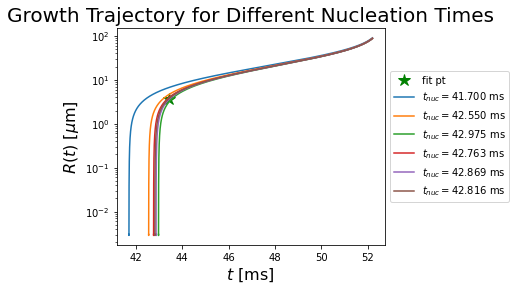

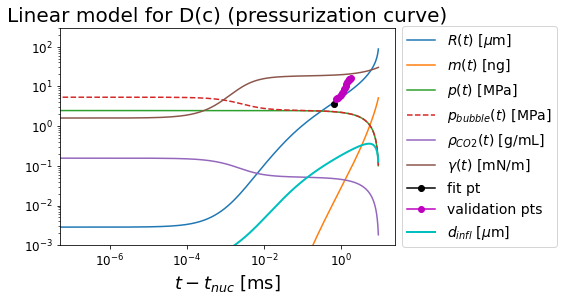

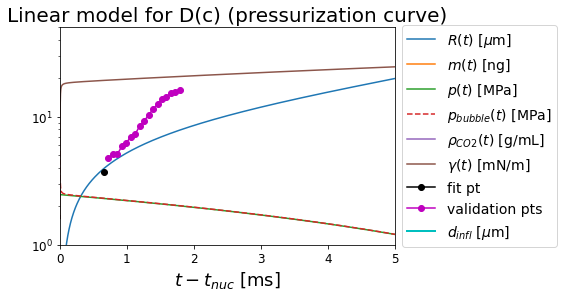

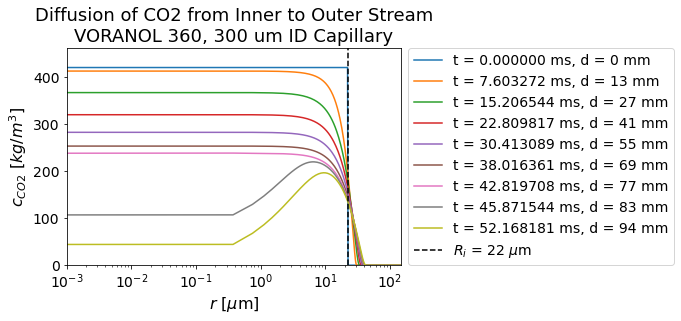

In [68]:
ax, c, r_arr = plot_pred(0.95*L, eps_params, D_dp, 400)

0% complete, t = 0.000 ms.
10% complete, t = 4.955 ms.
20% complete, t = 9.893 ms.
30% complete, t = 14.848 ms.
40% complete, t = 19.786 ms.
50% complete, t = 24.741 ms.
60% complete, t = 29.678 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.571 ms.
90% complete, t = 44.507 ms.
0% complete, t = 0.000 ms.
10% complete, t = 4.955 ms.
20% complete, t = 9.893 ms.
30% complete, t = 14.848 ms.
40% complete, t = 19.786 ms.
50% complete, t = 24.741 ms.
60% complete, t = 29.678 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.571 ms.
90% complete, t = 44.518 ms.
t_nuc = 41.700 ms and error in R is 1.5220.
0% complete, t = 0.000 ms.
10% complete, t = 4.955 ms.
20% complete, t = 9.893 ms.
30% complete, t = 14.848 ms.
40% complete, t = 19.786 ms.
50% complete, t = 24.741 ms.
60% complete, t = 29.678 ms.
70% complete, t = 34.616 ms.
80% complete, t = 39.571 ms.
90% complete, t = 44.506 ms.
t_nuc = 42.550 ms and error in R is 0.7270.
0% complete, t = 0.000 ms.
10% complete, t = 4.955 ms.

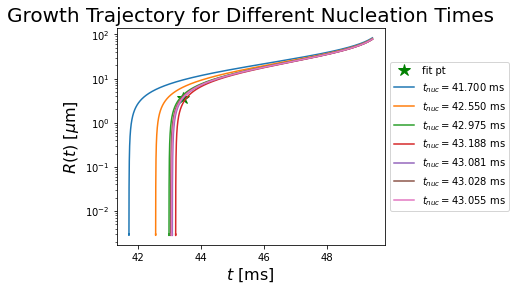

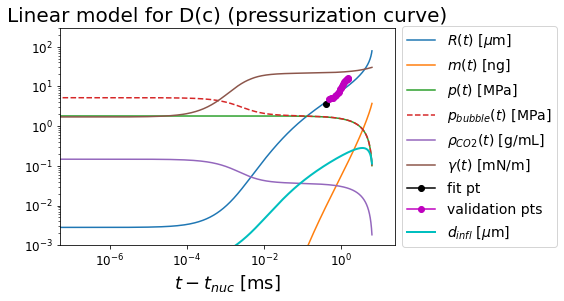

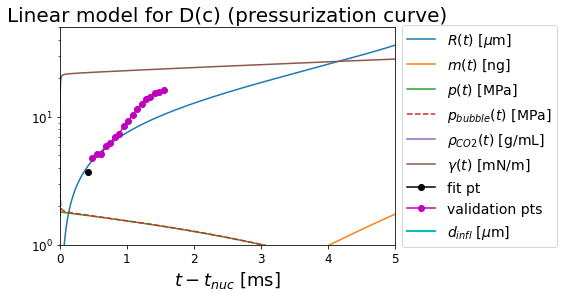

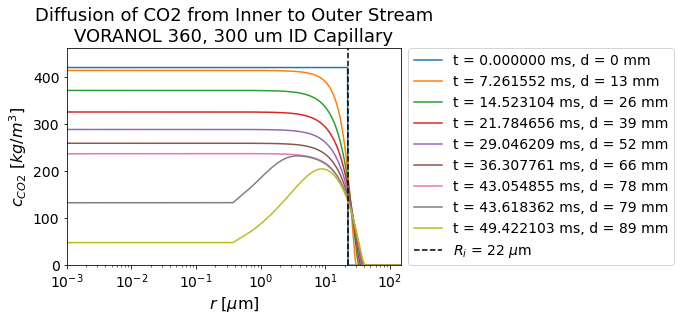

In [69]:
ax, c, r_arr = plot_pred(0.9*L, eps_params, D_dp, 400)

### Plot Results of Fitting Growth Function to Measured Bubble Size

Model prediction at fit point is R = 4.078079 um.


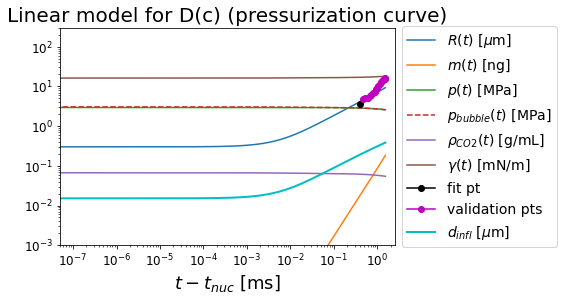

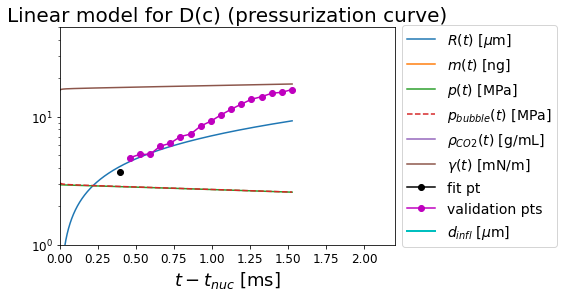

import plot.diffn as pltd



## Use Logarithmic Grid with Adaptive Meshing

Higher accuracy without too much computation **was expected** but I realized on February 18, 2021, that the accuracy was only a lucky cancellation of errors because I was using a finite-difference stencil for uniform grids on a non-uniform grid in the method `bubble.calc_dmdt_dcdr_fix_D()`, which underestimated the gradient at the bubble interface and corrected for the overestimate in bubble size at late times.

**Instead of adaptive meshing, I will currently use a uniform mesh, which is more accurate and faster.**

In [23]:
reload(diffn)
reload(bubble)
reload(bubbleflow)
reload(an)
reload(pltb)


def plot_pred_adapt(L, eps_params, N, eta_ratio=1):
    dt, p_s, R_nuc, _, p_in, v, polyol_data_file, eos_co2_file = eps_params
    dt = 1E-15 # keeps time step short enough to start
    eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

    # fits results to bubble growth model
    growth_fn = bubbleflow.sheath_incompressible
    i_t = 2 # index of t_bub in output of growth_fn
    i_R = 10 # index of R in output of growth_fn
    sigma_R = 0.03 # tolerance of error in radius

    # fixed parameters
    dr = 1E-6
    grid_fn = diffn.make_r_arr_log
    dcdt_fn = diffn.calc_dcdt_sph_vary_D_nonuniform
    remesh_fn = diffn.remesh_curv
    remesh_freq = 1000 # heuristic
    interp_kind = 'linear'
    adapt_freq = 5
    D_fn = D_p
        
    D_max = D_fn(500) # [m^2/s]
    R_max = R_o
    r_arr = grid_fn(N, R_o, dr=dr)
    d = np.min(np.diff(r_arr))
    dt_sheath = 0.5*d**2/D_max



    args = [eps_params, R_max, N, R_i, dt_sheath]
    dict_args = {'remesh_fn' : diffn.remesh_curv, 'remesh_params' : {'interp_kind' : interp_kind}, 'D_fn' : D_fn,
                 'remesh_freq' : remesh_freq, 'grid_fn' : grid_fn,'dcdt_fn' : dcdt_fn,
                 'grid_params' : {'dr' : dr}, 't_f' : t_bubbles[-1], 'eta_ratio' : eta_ratio}

    i_t_nuc = 0

    # increases maximum iterations
    max_iter = 15

    # bounds on nucleation time
    t_nuc_lo = 0.038 # [s]
    t_nuc_hi = 0.0434 # [s]

    # opens figure to show results of different guesses for bubble nucleation time
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # uses modified shooting method to estimate the nucleation time
    t_nuc, output = an.fit_growth_to_pt(t_bubble, R_bubbles[0], t_nuc_lo, t_nuc_hi, growth_fn, args,
                         i_t_nuc, sigma_R=sigma_R, ax=ax, max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args)

    # unpacks output
    t_flow, c, t_bub, m, D, p, p_bub, if_tension, c_bub, c_bulk, R, \
                rho_co2, v, r_arr_data = output
    # prints pressure in stream upon nucleation of bubble
    print('p [Pa]', p[0])
    # groups results for plotting
    props_list_fit = (R, m, p, p_bub, rho_co2, if_tension)
    
    c_s = [c_bulk] 

    # log time axis
    x_lim = [0.00000005, 10]
    y_lim = [0.001, 300]
    x_log = True
    title = 'Linear model for D(c) (pressurization curve)'
    ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], t_R=(t_bub, props_list_fit[0]),
                        non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_s[0])
    ax.plot(ax.get_xlim(), [R_i*m_2_um, R_i*m_2_um], 'k--', label=r'$R_i$ [$\mu$m]')
    pltg.legend(ax)

    # linear time axis
    y_lim = [1, 50] # focuses on bubble's observable growth
    x_log = False
    ax = pltb.all_props(t_bub, t_nuc, props_list_fit, x_log=x_log, x_lim=x_lim, y_lim=y_lim, title=title)
    ax = pltb.measured(ax, t_nuc, t_bubbles[0], t_bubbles[1:], R_bubbles[0], R_bubbles[1:], non_sph_R=0.5*R_i)
    ax = pltb.d_infl(ax, t_bub, t_nuc, props_list_fit, c_s[0])
    ax.plot(ax.get_xlim(), [R_i*m_2_um, R_i*m_2_um], 'k--', label=r'$R_i$ [$\mu$m]')

    pltg.legend(ax)
    
    # plot concentration profile
    n_plot = 5

    ax = pltd.sheath_remesh(np.asarray(t_flow), r_arr_data, c, R_i, R_o, v, c_s[0], n_plot, t_nuc=t_nuc)
    ax.set_xscale('log')
    ax.set_xlim([1E-3, R_o*m_2_um])
    pltg.legend(ax)
    
    return ax, c[-1], r_arr_data[0][-1]

### Demonstrate Convergence of Results for Adaptive Meshing

1.0077249278535205
1.0077249278535205
0% complete, t = 0.000 ms.
10% complete, t = 4.485 ms.
20% complete, t = 8.970 ms.
30% complete, t = 13.455 ms.
40% complete, t = 17.940 ms.
50% complete, t = 22.426 ms.
60% complete, t = 26.911 ms.
70% complete, t = 31.396 ms.
80% complete, t = 35.881 ms.
regridding
1.0077249278535205
90% complete, t = 40.168 ms.
1.0077249278535205
0% complete, t = 0.000 ms.
10% complete, t = 4.485 ms.
20% complete, t = 8.970 ms.
30% complete, t = 13.455 ms.
40% complete, t = 17.940 ms.
50% complete, t = 22.426 ms.
60% complete, t = 26.911 ms.
70% complete, t = 31.396 ms.
80% complete, t = 35.881 ms.
90% complete, t = 40.366 ms.
regridding
1.0077249278535205
t_nuc = 40.700 ms and error in R is 0.2274.
1.0077249278535205
0% complete, t = 0.000 ms.
10% complete, t = 4.485 ms.
20% complete, t = 8.970 ms.
30% complete, t = 13.455 ms.
40% complete, t = 17.940 ms.
50% complete, t = 22.426 ms.
60% complete, t = 26.911 ms.
70% complete, t = 31.396 ms.
80% complete, t = 35

StopIteration: 

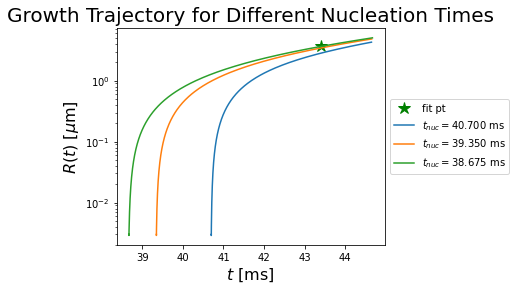

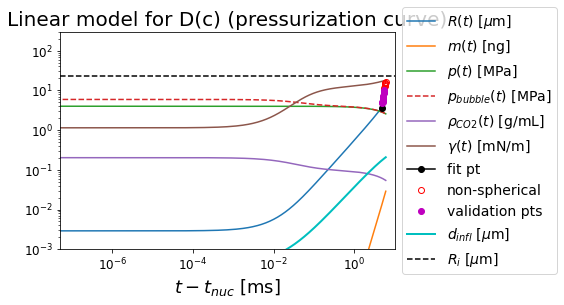

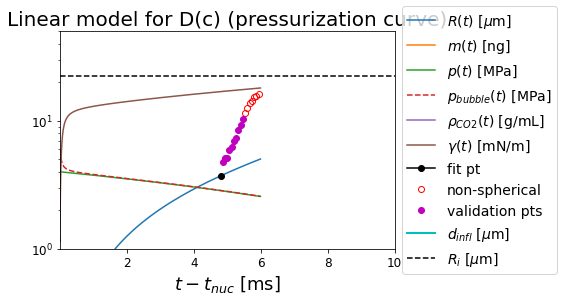

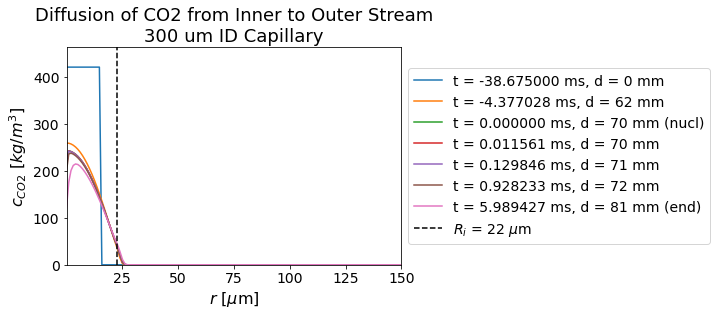

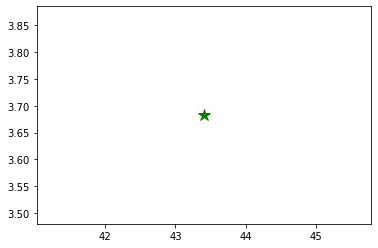

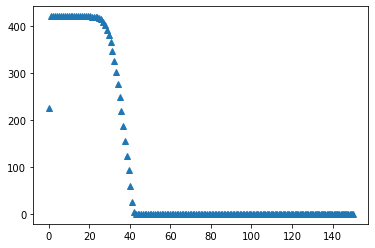

In [25]:
N_ = [100, 200]

eta_ratio = 300/4815

for N in N_:
    ax, c, r_arr  = plot_pred_adapt(L, eps_params, N, eta_ratio=eta_ratio)
    ax.set_xscale('linear')




1.0163217531077102
1.0163217531077102
0% complete, t = 0.000 ms.
remeshed
10% complete, t = 4.461 ms.
remeshed
remeshed
20% complete, t = 8.923 ms.
remeshed
remeshed
30% complete, t = 13.384 ms.
remeshed
40% complete, t = 17.843 ms.
remeshed
remeshed
50% complete, t = 22.304 ms.
remeshed


C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubbleflow.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax.set_title('before remeshing')


remeshed
60% complete, t = 26.766 ms.


C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubbleflow.py:603: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if remeshed and len(t_flow) > 1:
C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubbleflow.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax.set_title('before remeshing')


remeshed
70% complete, t = 31.227 ms.
remeshed


C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubbleflow.py:603: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if remeshed and len(t_flow) > 1:
C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubbleflow.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax.set_title('before remeshing')
C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubbleflow.py:6

remeshed
80% complete, t = 35.686 ms.


C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubbleflow.py:603: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if remeshed and len(t_flow) > 1:
C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubbleflow.py:609: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax.set_title('before remeshing')


remeshed
regridding
1.0163217531077102
mass in bubble decreased--density higher than bulk
rho_co2 209.8212099032302


C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubbleflow.py:530: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


StopIteration: 

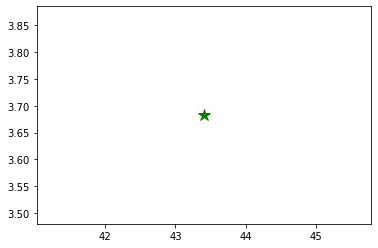

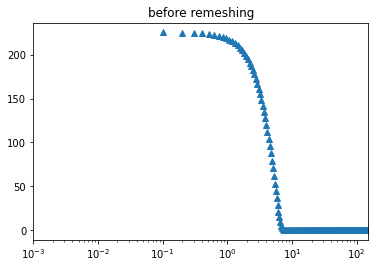

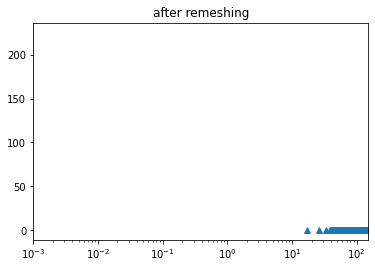

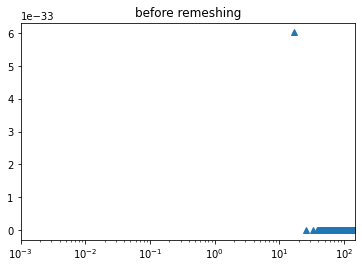

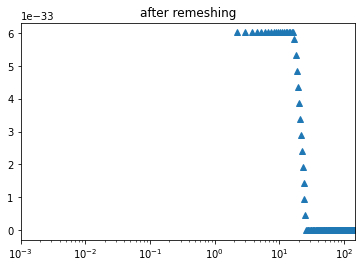

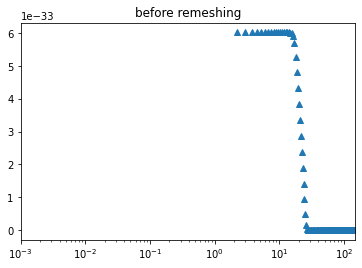

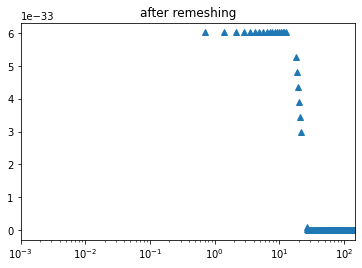

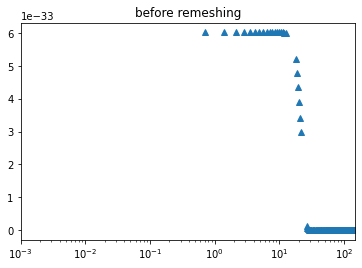

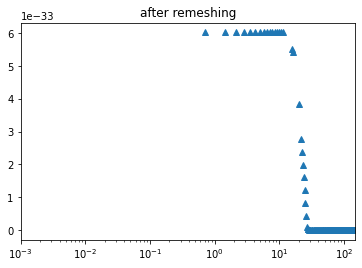

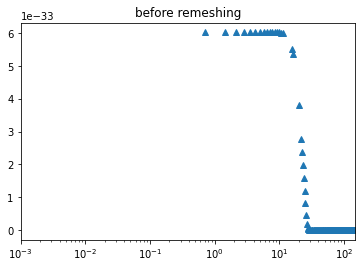

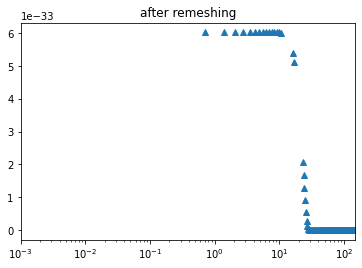

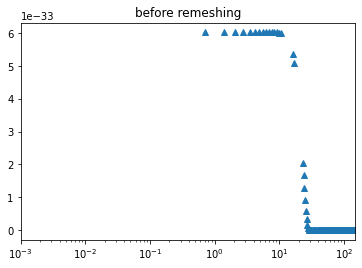

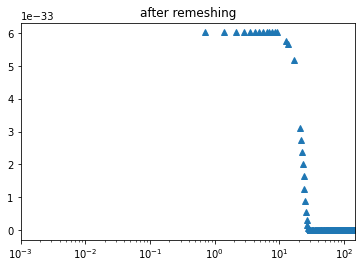

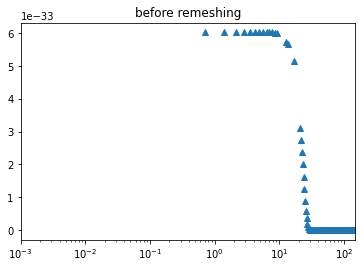

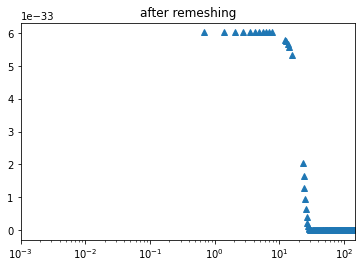

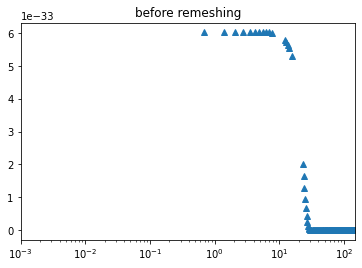

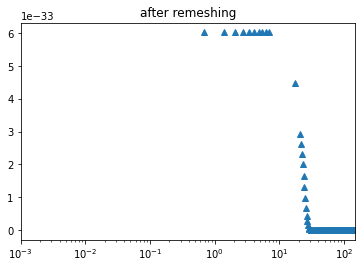

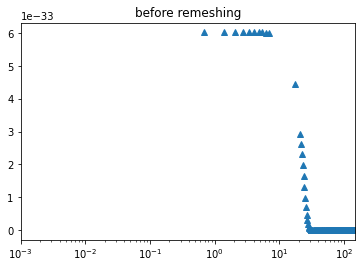

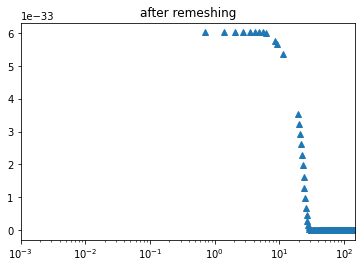

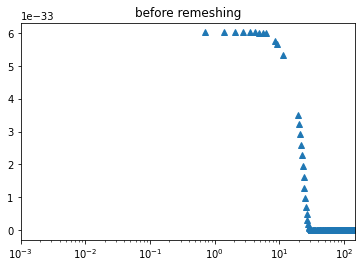

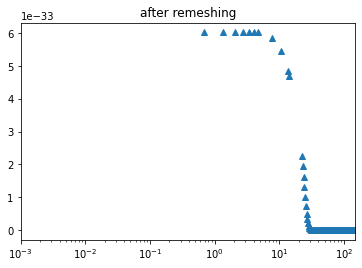

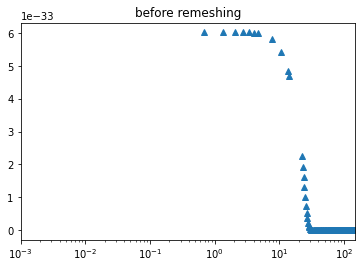

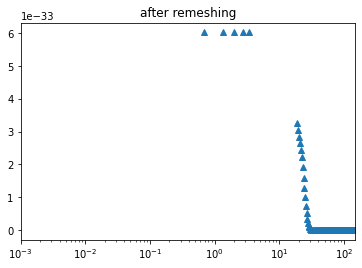

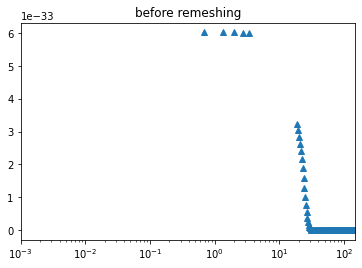

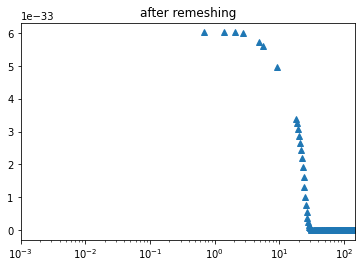

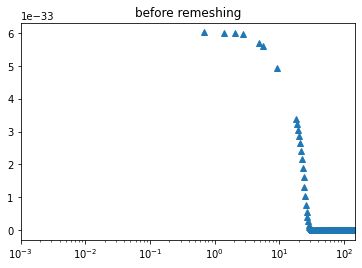

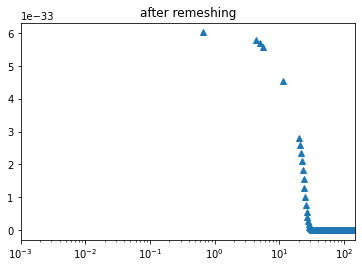

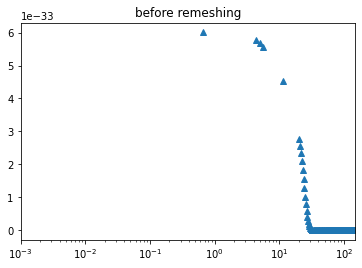

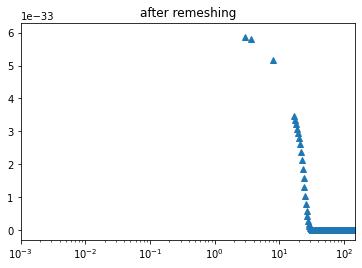

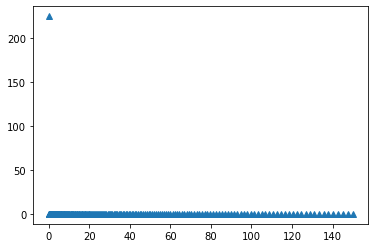

In [12]:
reload(diffn)
reload(bubbleflow)
ax, c, r_arr  = plot_pred_adapt(L, eps_params, 200)
ax.set_xscale('linear')

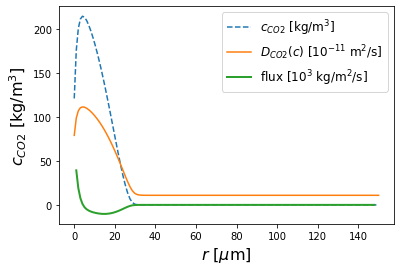

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111)

import finitediff as fd

dcdr_arr = fd.dydx_cd_2nd(np.asarray(c), r_arr[1] - r_arr[0])
D_arr = D_p(np.asarray(c))

ax.plot(r_arr*m_2_um, c, '--', label=r'$c_{CO2}$ [kg/m$^3$]')
ax.plot(r_arr*m_2_um, 1E11*D_arr, label=r'$D_{CO2}(c)$ [$10^{-11}$ m$^2$/s]')
ax.plot(r_arr[1:-1]*m_2_um, D_arr[1:-1]*dcdr_arr*1000, lw=2, label=r'flux [$10^3$ kg/m$^2$/s]')


ax.set_xlabel(r'$r$ [$\mu$m]', fontsize=16)
ax.set_ylabel(r'$c_{CO2}$ [kg/m$^3$]', fontsize=16)
ax.legend(fontsize=12)

1.0077249278535205
1.0077249278535205
0% complete, t = 0.000 ms.
10% complete, t = 4.485 ms.
20% complete, t = 8.970 ms.
30% complete, t = 13.455 ms.
40% complete, t = 17.940 ms.
50% complete, t = 22.426 ms.
60% complete, t = 26.911 ms.
70% complete, t = 31.396 ms.
80% complete, t = 35.881 ms.
regridding
1.0077249278535205
90% complete, t = 40.178 ms.
1.0077249278535205
0% complete, t = 0.000 ms.
10% complete, t = 4.485 ms.
20% complete, t = 8.970 ms.
30% complete, t = 13.455 ms.
40% complete, t = 17.940 ms.
50% complete, t = 22.426 ms.
60% complete, t = 26.911 ms.
70% complete, t = 31.396 ms.
80% complete, t = 35.881 ms.
90% complete, t = 40.366 ms.
regridding
1.0077249278535205
t_nuc = 40.700 ms and error in R is 0.1842.
1.0077249278535205
0% complete, t = 0.000 ms.
10% complete, t = 4.485 ms.
20% complete, t = 8.970 ms.
30% complete, t = 13.455 ms.
40% complete, t = 17.940 ms.
50% complete, t = 22.426 ms.
60% complete, t = 26.911 ms.
70% complete, t = 31.396 ms.
80% complete, t = 35

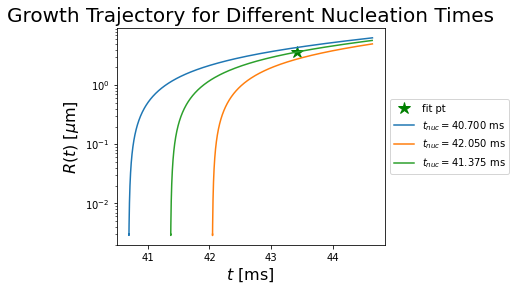

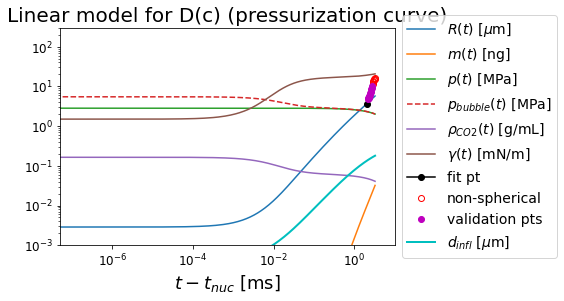

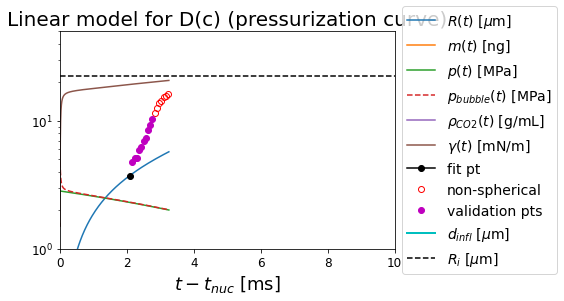

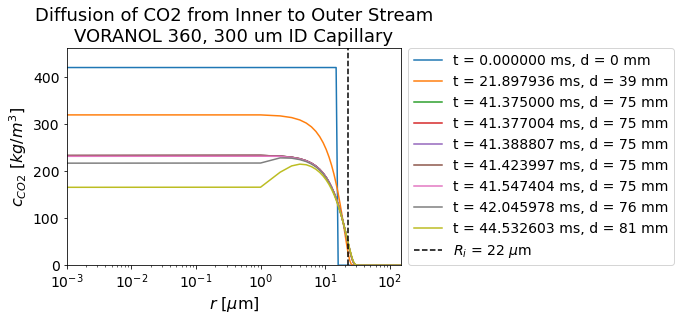

In [102]:
%%time

ax, c, r_arr = plot_pred_adapt(0.95*L, eps_params, 100)

1.0077249278535205
1.0077249278535205
0% complete, t = 0.000 ms.
10% complete, t = 4.485 ms.
20% complete, t = 8.970 ms.
30% complete, t = 13.455 ms.
40% complete, t = 17.940 ms.
50% complete, t = 22.426 ms.
60% complete, t = 26.911 ms.
70% complete, t = 31.396 ms.
80% complete, t = 35.881 ms.
regridding
1.0077249278535205
90% complete, t = 40.157 ms.
1.0077249278535205
0% complete, t = 0.000 ms.
10% complete, t = 4.485 ms.
20% complete, t = 8.970 ms.
30% complete, t = 13.455 ms.
40% complete, t = 17.940 ms.
50% complete, t = 22.426 ms.
60% complete, t = 26.911 ms.
70% complete, t = 31.396 ms.
80% complete, t = 35.881 ms.
90% complete, t = 40.366 ms.
regridding
1.0077249278535205
t_nuc = 40.700 ms and error in R is 0.7120.
1.0077249278535205
0% complete, t = 0.000 ms.
10% complete, t = 4.485 ms.
20% complete, t = 8.970 ms.
30% complete, t = 13.455 ms.
40% complete, t = 17.940 ms.
50% complete, t = 22.426 ms.
60% complete, t = 26.911 ms.
70% complete, t = 31.396 ms.
80% complete, t = 35

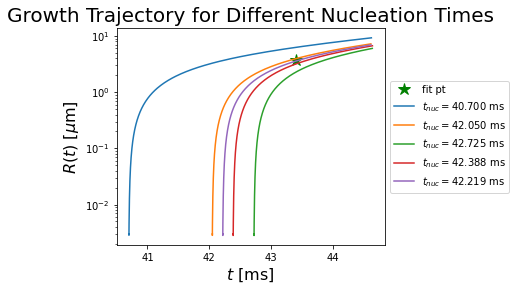

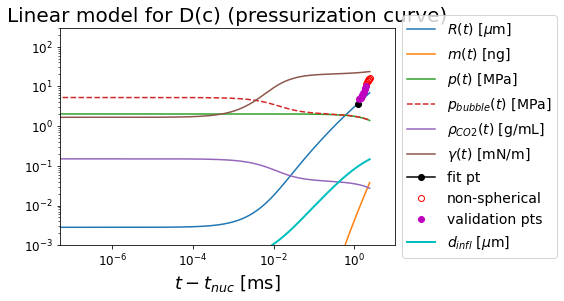

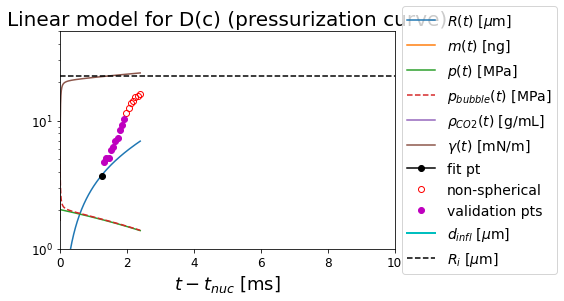

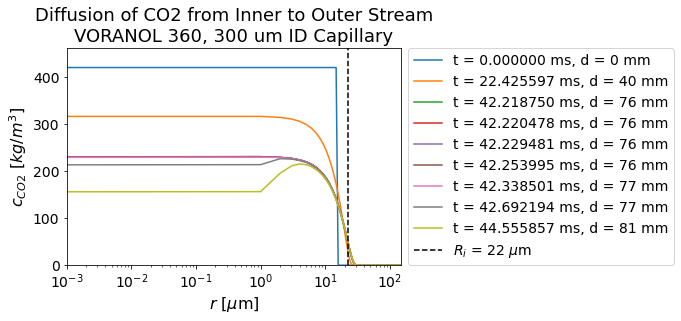

In [103]:
%%time 

ax, c, r_arr = plot_pred_adapt(0.9*L, eps_params, 100)

In [51]:
import pickle as pkl

# loads parameters of experiment
data_filepath = '../bubble-tracking/data/sd301_co2/20210207_88bar/sd301_co2_15000_001_100_0335_79_100_04_10/' + \
                'std_full/f_7205_1_9232.pkl'
with open(data_filepath, 'rb') as f:
    data = pkl.load(f)
    
print(data.keys())
# computes flow parameters 
# defines diffusivity function
# loads data from bubble-tracking
# fits model to first data point
# plots results

dict_keys(['bubbles', 'frame IDs', 'metadata'])


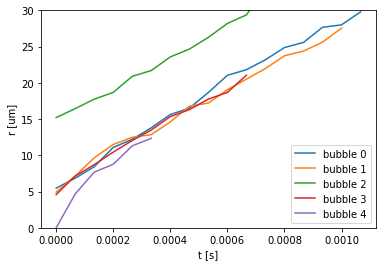

In [53]:
bubbles = data['bubbles']

fig = plt.figure()
ax = fig.add_subplot(111)


for key in bubbles:
    bubble = bubbles[key]
    on_border = bubble.get_props('on border')
    R_all = bubble.get_props('radius') # [um]
    R = [R_all[i]*1.34*2.29 for i in range(len(R_all)) if not on_border[i]]
    fps = bubble.get_metadata('fps')
    t = np.arange(len(R))/fps # [s]
    
    # plot
    ax.plot(t, R, label='bubble {0:d}'.format(bubble.get_metadata('ID')))
    
ax.set_xlabel('t [s]')
ax.set_ylabel('r [um]')
ax.set_ylim([0, 30])
ax.legend()
